In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import FiniteCluster, TranslationOperator
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .99
TOLERANCE_ONE_SIDE = .0005

In [2]:
def get_original_atom(uiso):
    original_atom = FiniteCluster(atoms_info=pd.DataFrame([[0, 0, 0, 1, uiso, 1.0]],
                        columns=["x", "y", "z", "num_electrons", "uiso", "occupancy"]))
    return original_atom

def calc_variance_sample_size_from_nickel(original_atom, disp):
    sample_size, _ = original_atom.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=TranslationOperator(direction=[0,0,1], displacement=disp),
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='JS',
        )
    return sample_size

def compute_sbm(uiso, disp):
    original_atom = get_original_atom(uiso)
    sample_size = calc_variance_sample_size_from_nickel(original_atom, disp)
    num_samples = [max(int(sample_size[1]), 50000), max(int(sample_size[2]), 50000)]
    measure = original_atom.calc_symmetry_breaking_measure(num_samples=num_samples, 
                                                           operator=TranslationOperator(direction=[0,0,1], displacement=disp), 
                                                           method='JS') 
    return measure

uiso: 0.005, d: 0.14623115577889448, d/sqrt(uiso): 2.0680208374400535, d^2/uiso: 4.276710184086261, measure: 0.10139095941837009
uiso: 0.01, d: 0.17487437185929647, d/sqrt(uiso): 1.7487437185929646, d^2/uiso: 3.05810459331835, measure: 0.101009630045285
uiso: 0.02, d: 0.20954773869346732, d/sqrt(uiso): 1.4817262701245744, d^2/uiso: 2.1955127395772833, measure: 0.10016181148367337
uiso: 0.03, d: 0.23517587939698492, d/sqrt(uiso): 1.357788572767562, d^2/uiso: 1.8435898083381732, measure: 0.10106144421321689
uiso: 0.04, d: 0.25326633165829143, d/sqrt(uiso): 1.266331658291457, d^2/uiso: 1.6035958687911918, measure: 0.10020379885929372


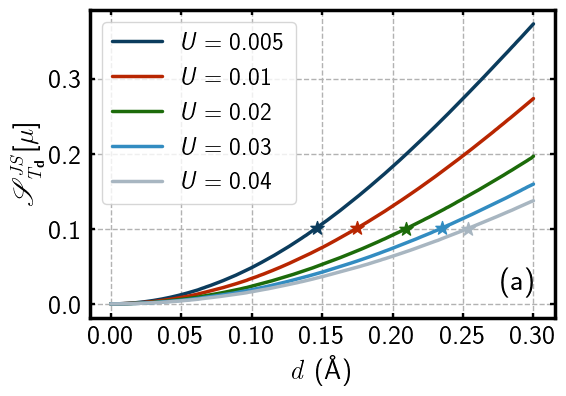

In [10]:
# Parameters
uiso_values = [0.005, 0.01, 0.02, 0.03, 0.04]
disp_values = np.linspace(0, 0.3, 200)
font_size = 20

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.style.use(bg_mpl_style)
rc('text', usetex=True)
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
})

for uiso in uiso_values:
    measures = [compute_sbm(uiso, disp) for disp in disp_values]
    ax.plot(disp_values, measures, label=fr'$U = {uiso}$')
    # Determine the point where measure reaches 0.95
    for i, measure in enumerate(measures):
        if measure >= 0.10:
            ax.scatter(disp_values[i], measure, marker='*', s=100, zorder=3)
            print(f"uiso: {uiso}, d: {disp_values[i]}, d/sqrt(uiso): {disp_values[i]/np.sqrt(uiso)}, d^2/uiso: {disp_values[i]**2/uiso}, measure: {measure}")
            break
        
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size) 
ax.legend(loc='upper left', fontsize=18)
ax_text = fig.add_axes([0.81, 0.18, 0, 0])
ax_text.text(0, 0, '(a)', fontsize=22)
ax_text.set_axis_off()

ax.set_xlabel(r'$\mathit{d}$ ($\mathrm{\AA}$)', fontsize=font_size)
ax.set_ylabel(r'$\mathscr{S}^{\mathit{JS}}_{\mathit{T}_\mathbf{d}}[\mu]$', fontsize=font_size)
ax.grid(True)

plt.show()
fig.savefig('../figs/two_atoms/two_atom.pdf')

In [12]:
# Parameters
uiso_values = np.linspace(0.005, 0.04, 50)
disp_values = np.linspace(0, 0.3, 200)
# Data storage for plotting
threshold_ds = []

for uiso in tqdm(uiso_values):
    found = False  # Flag to indicate if the threshold has been found
    for disp in disp_values:
        measure_curr = compute_sbm(uiso, disp)
        if measure_curr >= 0.10:
            threshold_ds.append(disp)
            found = True
            break
            
    if not found:
        threshold_ds.append(None)  # Append None if no threshold was found
        
df = pd.DataFrame({'uiso_values': uiso_values, 'threshold_ds': threshold_ds})
csv_filepath = '../figs/two_atoms/two_atom_threshold.csv'
df.to_csv(csv_filepath, index=False)


100%|██████████| 50/50 [13:31<00:00, 16.23s/it]


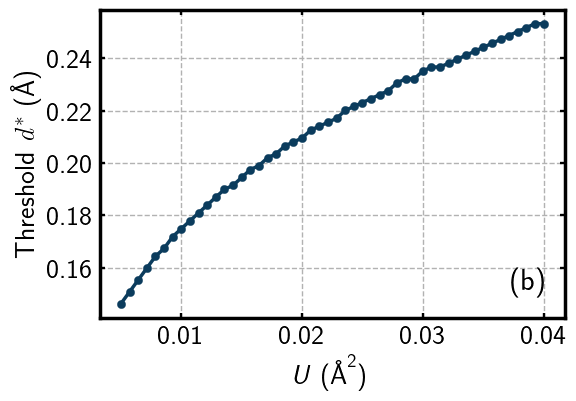

In [13]:
df = pd.read_csv('../figs/two_atoms/two_atom_threshold.csv')
uiso_values, threshold_ds = df['uiso_values'].values, df['threshold_ds'].values

# Plotting setup
uiso_values = np.linspace(0.005, 0.04, 50)
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
font_size = 20

# Plotting
plt.style.use(bg_mpl_style)
rc('text', usetex=True)
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
})
        
# Plotting threshold d vs uiso
ax.plot(uiso_values, threshold_ds, marker='o', linestyle='-')
ax.set_xlabel(r'$U$ ($\mathrm{\AA}^2$)', fontsize=font_size)
ax.set_ylabel(r'Threshold $\mathit{d}^*$ ($\mathrm{\AA}$)', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size) 

ax_text = fig.add_axes([0.81, 0.18, 0, 0])
ax_text.text(0, 0, '(b)', fontsize=22)
ax_text.set_axis_off()

ax.grid(True)
plt.show()
fig.savefig('../figs/two_atoms/two_atom2.pdf')